In [1]:
import sys
sys.path.append('C:/maldb/python/mlp/')

import tensorflow as tf
from tensorflow import keras
import numpy as np
from ionizer import *

[ 2.90000000e+01  3.64219460e+03  2.41379310e-01  7.73758621e+01
  9.19075794e+00  2.86116401e+00  6.89655172e-02  6.89655172e-02
  3.44827586e-02  3.44827586e-02  6.89655172e-02  3.44827586e-02
  3.44827586e-02  3.44827586e-02  1.03448276e-01  3.44827586e-02
  3.44827586e-02  3.44827586e-02  3.44827586e-02  3.44827586e-02
  6.89655172e-02  3.44827586e-02  3.44827586e-02  3.44827586e-02
  6.89655172e-02  1.03448276e-01 -1.85000000e+01  3.29600000e+01
 -2.40800000e+01  7.66900000e+03 -2.72420000e+02  2.69380000e+02
  6.23100000e+01  2.96800000e+01  2.93600000e+01  3.01200000e+01
  2.76500000e+01  4.69000000e+01  1.52000000e+00  2.53000000e+00
  5.80000000e+00  1.20050000e+02  1.45462000e+03  3.67200000e+00
  5.80000000e+00  1.34000000e+00 -7.06000000e+00 -1.81000000e+00
 -1.77000000e+00 -4.10000000e-01  4.92310000e+02  1.28360000e+02
  6.34500000e+00 -2.43000000e-01  1.65500000e+00  8.80000000e-02
 -1.55380000e+02 -2.41000000e+00  2.85200000e+01  1.79630000e+02
  1.34120000e+02 -3.70000

In [2]:
#To avoid feeding wildly varying numbers into the NN, we normalize things by subtracting the mean from each feature value and dividing by the standard deviation
def normalize_data(data):
    mean = data.mean(axis=0)
    data -= mean

    std = data.std(axis=0)
    data /= std
    
    return data

#When we shuffle our training and test arrays, we need to shuffle them in unison so that the indices in the labels array line up with their corresponding peptide in the training array.
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [3]:
#Get the data from the excel sheet, calculate feature vectors for each entry (row) using ionizers.py
train_data, train_labels = get_ionizer_training_data('C:/maldb/python/mlp/data/ionizers.csv')

train_data = np.nan_to_num(train_data, nan=1.0)

#Let's check out how many samples we have and the number of features we're getting from our feature vectors.
print(train_data.shape) 

#Assign these values into variables for later.
#num_samples will be used to split the data into partitions.
#feature_vector_length is required to tell the input layer what shape it is expected to receive
num_samples = train_data.shape[0]
feature_vector_length = train_data.shape[1]


split = round(0.80 * num_samples) #makes an 85/15 split of the dataset

(612, 559)


In [4]:
x_train = normalize_data(train_data).astype('float32')
y_train = train_labels.astype('float32')

In [30]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(128, activation='relu', input_shape=(feature_vector_length,)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

#We should randomly shuffle our data before splitting it into training and test sets
#The peptides were deposited into the array on a per-protein basis, so each protein may have a specific AA composition, properties etc.
#Thus, if the first 85% of our data were soluble proteins, and the last 15% were membrane proteins, we are likely to have poor prediction since our model never saw/had a chance to learn on membrane peptides!

#Shuffle!
x_train, y_train = unison_shuffled_copies(x_train, y_train)

In [31]:
#Slice the training and validation sets
partial_x_train = x_train[:split]
x_val = x_train[split:]

partial_y_train = y_train[:split]
y_val = y_train[split:]

#Train the model
epochs = 20
history = model.fit(partial_x_train, partial_y_train, epochs=epochs, validation_data=(x_val, y_val))

Epoch 1/20
16/16 [==============================] - 1s 12ms/step - loss: 0.7355 - accuracy: 0.6696 - val_loss: 1.1015 - val_accuracy: 0.4672
Epoch 2/20
16/16 [==============================] - 0s 1ms/step - loss: 0.5489 - accuracy: 0.7396 - val_loss: 0.4996 - val_accuracy: 0.7213
Epoch 3/20
16/16 [==============================] - 0s 1ms/step - loss: 0.4832 - accuracy: 0.7716 - val_loss: 0.5930 - val_accuracy: 0.6803
Epoch 4/20
16/16 [==============================] - 0s 1ms/step - loss: 0.4543 - accuracy: 0.7828 - val_loss: 0.7530 - val_accuracy: 0.6230
Epoch 5/20
16/16 [==============================] - 0s 1ms/step - loss: 0.4887 - accuracy: 0.7485 - val_loss: 0.7820 - val_accuracy: 0.5820
Epoch 6/20
16/16 [==============================] - 0s 1ms/step - loss: 0.4397 - accuracy: 0.8288 - val_loss: 0.5326 - val_accuracy: 0.7213
Epoch 7/20
16/16 [==============================] - 0s 1ms/step - loss: 0.3669 - accuracy: 0.8435 - val_loss: 0.5732 - val_accuracy: 0.7295
Epoch 8/20
16/16 [=

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


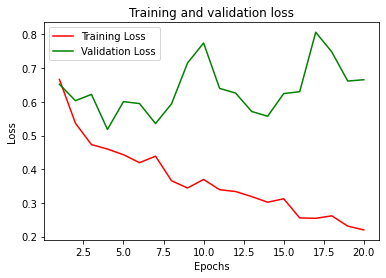

In [28]:
import matplotlib.pyplot as plt

history_dict = history.history
print(history_dict.keys())
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

e = range(1, epochs + 1)

plt.plot(e, loss_values, 'r-', label='Training Loss')
plt.plot(e, val_loss_values, 'g-', label='Validation Loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


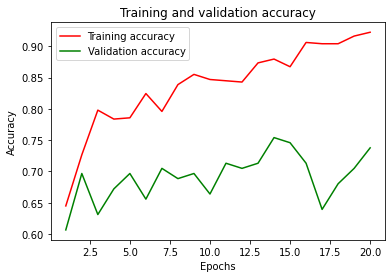

In [29]:
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
plt.plot(e, acc_values, 'r-', label='Training accuracy')
plt.plot(e, val_acc_values, 'g-', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()